In [1]:
using Plots,DelimitedFiles,Dierckx,Integrals,Cubature

Generic Functions

In [2]:
function FermiDirac(E,μ,kB,Tel)
    return 1/(exp((E-μ)/(kB*Tel))+1)
end

function generate_DOS(File::String,n,FE)
    TotalDOS::Matrix{<:Real}=readdlm(File,skipstart=3)
    return Spline1D(TotalDOS[:,1].+FE,TotalDOS[:,2].*n,bc="nearest")
end

generate_DOS (generic function with 1 method)

Relaxation Times

In [3]:
function current_tauee(τ,E,μ,kB,Tel)
    return τ*μ^2 /((E-μ)^2 +(pi*kB*Tel)^2)
end

function FLT_tauee(rs,E,μ,hbar)
    return 2.5019*rs*(E-μ)^2/hbar
end

FLT_tauee (generic function with 1 method)

Random K-approximation

In [1]:
function matrixelements(DOS,ω,hbar,μ,E)
    return sqrt(3)*pi*hbar*ω/128/μ^2/DOS(E)^3
end

function innerintegral(y,u,p)
    Threads.@threads for i in 1:length(u)
        int(x,p)=p[2](x)*p[2](p[1]+x-u[i])*p[2](u[i])
        prob=IntegralProblem(int,p[3]-p[1]-u[i],p[3])
        y[i]=solve(prob,HCubatureJL(initdiv=2),abstol=1e-4,reltol=1e-4).u
    end
end

function occindependentk(M,hbar,DOS,E,μ)
    p=[E,DOS,μ]
    int = BatchIntegralFunction(innerintegral,zeros(0))
    prob=IntegralProblem(int,(E,μ),p)
    sol=solve(prob,CubatureJLh(),abstol=1e-3,reltol=1e-3)
    return 2*pi/hbar*M
end

Getting Distriubtions etc.

In [5]:
#= fneqdis = readdlm("fneqdis.txt")

fneq = fneqdis[:,2]
feq = FermiDirac.(egrid,μ,kB,Tel)
ftot = fneq.+feq
ftotspl = Spline1D(egrid,ftot,bc="nearest") =#

Variables

In [6]:
fneqdis = readdlm("MetaVersion/fneqdis.txt")
Tel=300.0
μ=5.53#fneqdis[621,1]
egrid=fneqdis[:,1].-(fneqdis[621,1]-5.53)
kB=8.617e-5
n=59
τ=0.546
hbar=0.6582
h=4.135
rs=1.65
ω=1.323
DOS = generate_DOS("DOS/Au_DOS.dat",n,μ)

Simple Approximations

In [ ]:
current=zeros(length(egrid))
FLT=zeros(length(egrid))
for (i,E) in enumerate(egrid)
    current[i]=current_tauee(τ,E,μ,kB,Tel)
    FLT[i]=1/FLT_tauee(rs,E,μ,hbar)
end

In [ ]:
plot(egrid,[current,FLT],label=["Current" "FLT"])

Evaluating Random K Approximation

In [ ]:
independentK=zeros(length(egrid))
for (i,E) in enumerate(egrid)
    M = matrixelements(DOS,ω,hbar,μ,E)
    independentK[i]=1/occindependentk(M,hbar,DOS,E,μ)
end

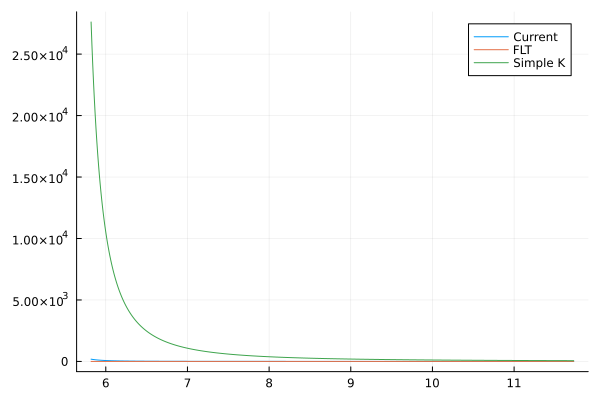

In [41]:
plot(egrid[650:end],[current,FLT,SimpleK],label=["Current" "FLT" "Simple K"])